In [28]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1" # GPU:0

from numba import cuda
cuda.select_device(0) # rm GPU from memory tf/keras
cuda.close()

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
from sklearn import set_config
import os

# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.over_sampling import ADASYN, RandomOverSampler
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, f1_score, make_scorer, roc_auc_score, confusion_matrix

from performance import plot_roc, plot_learning_curves
from lcfunctions import load_lasair_lc, lasair_clean, display_lightcurve, download_lasair_lc
from raw_processing import label_schemes

# from tensorflow.keras.utils import to_categorical
# from tensorflow import keras
# from tensorflow.keras import layers, regularizers
# from keras.utils import to_categorical
# from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model, Model
import tensorflow as tf
# from sklearn.utils import class_weight

from representations import getdiffs, backfilled_magnitudes, dmdt, interpolated_lcs, gminusr, dmdt_hist, multi_channel


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        # print(last_conv_layer_output.shape, preds)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_max(grads, axis=(0, 1))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

### Generate dataset

In [2]:
label_scheme = 'labels_2'

pd.options.display.max_columns = None
                     
dataset = pd.read_csv('../processed_data/AAVSOCVsZTFxmatch_21032023_BTS_manual_labelled.csv')
dataset = label_schemes(dataset)

dataset = dataset[dataset[label_scheme].notna()].reset_index(drop=True)
print(dataset[label_scheme].value_counts())
dataset.columns

dwarf_nova_SU_UMa    630
dwarf_nova_Z_Cam     174
nova_like            144
nova_like_VY_Scl     120
dwarf_nova_U_Gem     116
polar                114
int_polar             49
AMCVn                 46
nova                  46
Name: labels_2, dtype: int64


Index(['oid_ztf', 'oid_aavso', 'type_aavso', 'ra', 'dec', 'Eclipsing',
       'CV_Types', 'CV_subtypes', 'CV_subsubtypes', 'eclipse_clear',
       'manual_label', 'Clarity', 'labels_1', 'labels_2', 'labels_3',
       'labels_4'],
      dtype='object')

### View dataset lightcurves

In [13]:
date = '2023_03_25'
object = 'ZTF18aakynpt'
class_list = ['dwarf_nova_SU_UMa']
display_start = 0
display_end = 10
label_scheme = 'labels_2'

# Apply errorbars
error = False

if error == True:
        errColalerce1 = 'sigmapsf'
        errColalerce2 = 'sigmapsf_corr_revised'
        errCollasair1 = 'sigmapsf'
        errCollasair2 = 'dc_sigmag'
else:
    errColalerce1 = None
    errColalerce2 = None
    errCollasair1 = None
    errCollasair2 = None

# objlist = dataset[dataset[label_scheme].str.contains('DQ', na=False)]['Xmatch_obj'].iloc[display_start:display_end]
# objtype = dataset[dataset[label_scheme].str.contains('DQ', na=False)][label_scheme].iloc[display_start:display_end]
# name = dataset[dataset[label_scheme].str.contains('DQ', na=False)]['Name'].iloc[display_start:display_end]

print(f'Number of objects: {dataset[dataset[label_scheme].isin(class_list)].shape[0]}')

objlist = dataset[dataset[label_scheme].isin(class_list)]['oid_ztf'].iloc[display_start:display_end]
objtype = dataset[dataset[label_scheme].isin(class_list)][label_scheme].iloc[display_start:display_end]
aavso_name = dataset[dataset[label_scheme].isin(class_list)]['oid_aavso'].iloc[display_start:display_end]
aavso_type = dataset[dataset[label_scheme].isin(class_list)]['type_aavso'].iloc[display_start:display_end]
ra = dataset[dataset[label_scheme].isin(class_list)]['ra'].iloc[display_start:display_end]
dec = dataset[dataset[label_scheme].isin(class_list)]['dec'].iloc[display_start:display_end]
# Get the index of the object in the dataset
index = dataset[dataset[label_scheme].isin(class_list)].index[display_start:display_end]

i=0
for object, type, name, ra, dec, type_aavso, idx in zip(objlist, objtype, aavso_name, ra, dec, aavso_type, index):

    print(object, name, ra, dec)
    print(f'Our class label: {type}', f'AAVSO class label: {type_aavso}', f'Dataset index: {idx}', sep='\n')
    
    # Display lasair difference magnitude and apparent magnitude light curves.
    lc_lasair = load_lasair_lc(object, path=f'../lightcurves_dataset/lasair_{date}')
    lc_lasair_appmag = lasair_clean(lc_lasair, limit=25, magerrlim=1)

    # print('Lasair difference magnitude')
    # display_lightcurve(lc_lasair,x='jd',y='magpsf',errorCol=errCollasair1)
    print('Lasair apparent magnitude')
    display_lightcurve(lc_lasair_appmag,x='jd',y='dc_mag',errorCol=errCollasair2)
    i+=1

Number of objects: 630
ZTF17aaaenol ASASSN-V J000122.44+481658.1 0.3435 48.28272222
Our class label: dwarf_nova_SU_UMa
AAVSO class label: UG
Dataset index: 441
Lasair apparent magnitude


ZTF22abgglcz ATLAS22belw 3.626833333 43.2385
Our class label: dwarf_nova_SU_UMa
AAVSO class label: UG
Dataset index: 442
Lasair apparent magnitude


ZTF18abmnxnv CSS 091120:001019+410455 2.5805 41.08188889
Our class label: dwarf_nova_SU_UMa
AAVSO class label: UG
Dataset index: 443
Lasair apparent magnitude


ZTF18acpsefo Gaia19cnk 38.33083333 45.20741667
Our class label: dwarf_nova_SU_UMa
AAVSO class label: UG
Dataset index: 444
Lasair apparent magnitude


ZTF20abpqbgi Gaia20doe 33.452 46.49913889
Our class label: dwarf_nova_SU_UMa
AAVSO class label: UG
Dataset index: 445
Lasair apparent magnitude


ZTF18aayhqtj 2MASS J18511197+0131460 282.799875 1.5295
Our class label: dwarf_nova_SU_UMa
AAVSO class label: UGER
Dataset index: 478
Lasair apparent magnitude


ZTF18aawzsdg MGAB-V455 292.1796667 14.89380556
Our class label: dwarf_nova_SU_UMa
AAVSO class label: UGER
Dataset index: 479
Lasair apparent magnitude


ZTF18aazwekc MGAB-V1097 345.407 54.57858333
Our class label: dwarf_nova_SU_UMa
AAVSO class label: UGER
Dataset index: 480
Lasair apparent magnitude


ZTF18abakiqc MGAB-V322 328.3207083 56.17347222
Our class label: dwarf_nova_SU_UMa
AAVSO class label: UGER
Dataset index: 481
Lasair apparent magnitude


ZTF18aayhiqy BMAM-V371 313.328 50.81822222
Our class label: dwarf_nova_SU_UMa
AAVSO class label: UGER
Dataset index: 482
Lasair apparent magnitude


### Display individual object

In [41]:
# Display lasair difference magnitude and apparent magnitude light curves.

objects = ['ZTF18aawzsdg']

for object in objects:
    try:
        lc_lasair = load_lasair_lc(object, path=f'../lightcurves_dataset/lasair_{date}')
    except:
        # Create a folder within path for LCs if one does not exist
        if not os.path.exists(f'../lightcurves_dataset/lasair_non_dataset/cache'):
            os.makedirs(f'../lightcurves_dataset/lasair_non_dataset/cache')
        print('Not in dataset')
        download_lasair_lc([object], folderpath=f'../lightcurves_dataset/lasair_non_dataset', cache=f'../lightcurves_dataset/lasair_non_dataset/cache')
        lc_lasair = load_lasair_lc(object, path=f'../lightcurves_dataset/lasair_non_dataset')

    lc_lasair_appmag = lasair_clean(lc_lasair, limit=25, magerrlim=1)

    # print('Lasair difference magnitude')
    # display_lightcurve(lc_lasair,x='jd',y='magpsf',errorCol=errCollasair1)
    print('Lasair apparent magnitude')
    display_lightcurve(lc_lasair_appmag,x='jd',y='dc_mag',errorCol=errCollasair2)

Lasair apparent magnitude


### Download keras model and display the model architecture

### Dictionary of light curve information

In [42]:
# Create a dictionary of dictionary, where each sub-dictionary contains the light curve data for a given object
objectlist = ['ZTF18aawzsdg']

def lightcurve_dictionary(objectlist, lc_folder = '../lightcurves_dataset/lasair_2023_03_25'):

    lightcurves = {}
    for obj in objectlist:
        print(obj)

        try:
            lc_lasair = load_lasair_lc(obj, path=lc_folder)
        except:
            # Create a folder within path for LCs if one does not exist
            if not os.path.exists(f'../lightcurves_dataset/lasair_non_dataset/cache'):
                os.makedirs(f'../lightcurves_dataset/lasair_non_dataset/cache')
            print('Not in dataset')
            download_lasair_lc([obj], folderpath=f'../lightcurves_dataset/lasair_non_dataset', cache=f'../lightcurves_dataset/lasair_non_dataset/cache')
            lc_lasair = load_lasair_lc(obj, path=f'../lightcurves_dataset/lasair_non_dataset')

        lc_test = lc_lasair.copy()
        lc_appmag_test = lasair_clean(lc_test, limit=25, magerrlim=1)
        df_lc = lc_appmag_test.copy()
        df_lc_g = df_lc[df_lc['fid'] == 1].reset_index(drop=True)
        df_lc_r = df_lc[df_lc['fid'] == 2].reset_index(drop=True)

        lightcurves[obj] = {'g_mag': df_lc_g['dc_mag'].values, 
                            'r_mag': df_lc_r['dc_mag'].values,
                            'g_jd': df_lc_g['jd'].values,
                            'r_jd': df_lc_r['jd'].values
                            }
    
    return lightcurves
    

lightcurves = lightcurve_dictionary(objectlist)

ZTF18aawzsdg


### Obtain representation and reshape

In [43]:
# Get the representation.
# X_g, X_r, X_gjd, X_rjd = backfilled_magnitudes(lightcurves=lightcurves, n_pts=1000, backfill_value=0.0)
# X_g_hist, X_r_hist, a, b = dmdt_hist(lightcurves, bins=100, limit=10, dm=True, usepeaks=True)
X_g_int, X_r_int = interpolated_lcs(lightcurves, interp_pts=1000, true_cadence=False, backfill_value=0, cadence=1)
X_clr = gminusr(lightcurves, interp_pts=1000, true_cadence=False, backfill_value=0.0, cadence=1)[0]
# X_g_dmdthist = dmdt_hist(lightcurves, bins=100, limit=10, dm=False, usepeaks=True)[0]
# X_r_dmdthist = dmdt_hist(lightcurves, bins=100, limit=10, dm=False, usepeaks=True)[1]

# show = np.random.randint(0, len(X_g))
# plt.plot(X_g_int[show], '.')
# plt.gca().invert_yaxis()

# X_gr = multi_channel([X_g, X_r])
# X_gr_hist = multi_channel([X_g_hist, X_r_hist])
# Reshape the arrays.
# X_g = X_g.reshape(X_g.shape[0], X_g.shape[1], -1)


(1, 1000, 1)


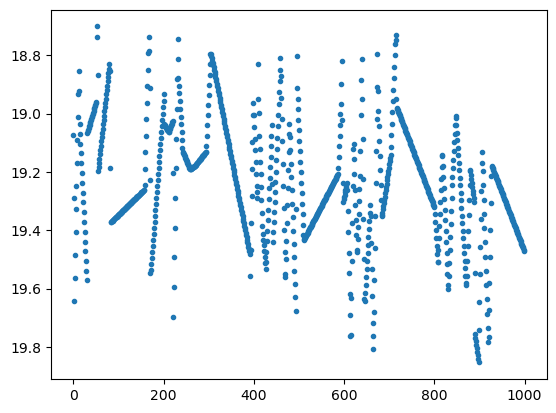

In [44]:
X_variant = X_g_int.reshape(X_g_int.shape[0], X_g_int.shape[1], -1)

# X_variant = multi_channel([X_g_dmhist.reshape(X_g_dmhist.shape[0], X_g_dmhist.shape[1], -1),
#                            X_r_dmhist.reshape(X_r_dmhist.shape[0], X_r_dmhist.shape[1], -1)])
X_multihead_1 = X_g_int.reshape(X_g_int.shape[0], X_g_int.shape[1], -1)
X_multihead_2 = X_r_int.reshape(X_r_int.shape[0], X_r_int.shape[1], -1)
X_multihead_3 = X_clr.reshape(X_clr.shape[0], X_clr.shape[1], -1)

print(X_multihead_3.shape)#, X_mulithead_1.shape, X_multihead_2.shape)

show = np.random.randint(0, len(X_variant))
plt.plot(X_variant[show], '.')
plt.gca().invert_yaxis()

### Load and display model and show class activations

Model: "model_27"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input1 (InputLayer)         [(None, 1000, 1)]            0         []                            
                                                                                                  
 input2 (InputLayer)         [(None, 1000, 1)]            0         []                            
                                                                                                  
 input3 (InputLayer)         [(None, 1000, 1)]            0         []                            
                                                                                                  
 i1Conv1 (Conv1D)            (None, 1000, 128)            4608      ['input1[0][0]']              
                                                                                           

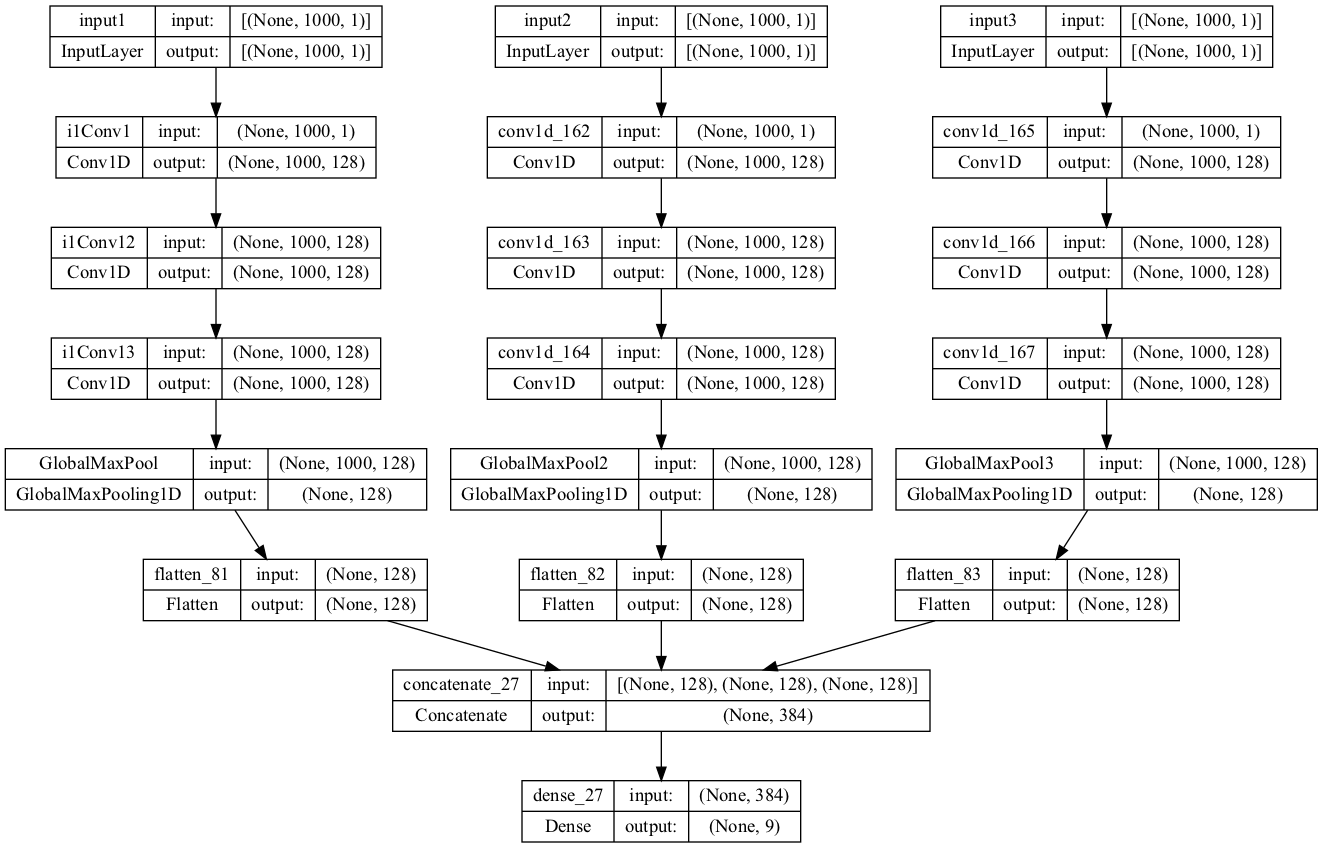

In [45]:
# Make model
from tensorflow.keras.utils import plot_model
model = load_model(f'../results/1dcnn/model/mh_g&r&clr_int_1000_ks35.h5')

model.summary()
plot_model(model, show_shapes=True, show_layer_names=True)

1/1 [==============================] - 0s 105ms/step
[7]


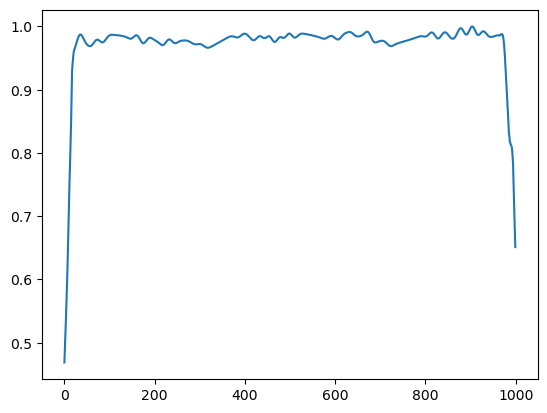

In [46]:

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict([X_multihead_1, X_multihead_2, X_multihead_3])
print(np.argmax(preds, axis=1))

# print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array=[X_multihead_1, X_multihead_2, X_multihead_3], model=model, last_conv_layer_name='i1Conv13', pred_index=3)

plt.plot(heatmap)

Lasair apparent magnitude


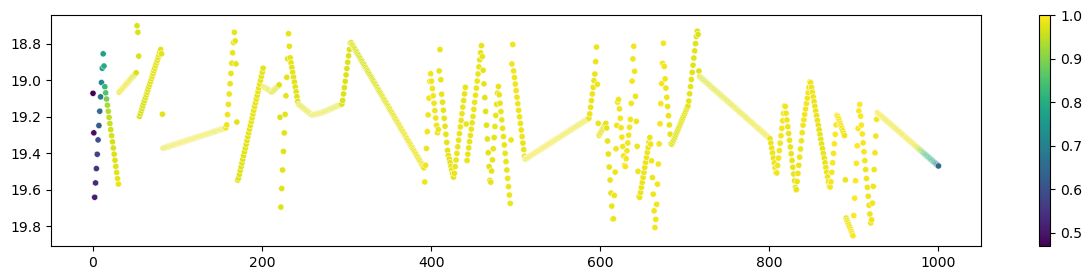

In [47]:
objects = objects
representation = X_multihead_1


for object in objects:
    try:
        lc_lasair = load_lasair_lc(object, path=f'../lightcurves_dataset/lasair_{date}')
    except:
        # Create a folder within path for LCs if one does not exist
        if not os.path.exists(f'../lightcurves_dataset/lasair_non_dataset/cache'):
            os.makedirs(f'../lightcurves_dataset/lasair_non_dataset/cache')
        print('Not in dataset')
        download_lasair_lc([object], folderpath=f'../lightcurves_dataset/lasair_non_dataset', cache=f'../lightcurves_dataset/lasair_non_dataset/cache')
        lc_lasair = load_lasair_lc(object, path=f'../lightcurves_dataset/lasair_non_dataset')

    lc_lasair_appmag = lasair_clean(lc_lasair, limit=25, magerrlim=1)

    # print('Lasair difference magnitude')
    # display_lightcurve(lc_lasair,x='jd',y='magpsf',errorCol=errCollasair1)
    print('Lasair apparent magnitude')
    display_lightcurve(lc_lasair_appmag,x='jd',y='dc_mag',errorCol=errCollasair2)


import seaborn as sns

# Plot the light curve for img_array using seaborn
plt.figure(figsize=(15, 3))
plt.gca().invert_yaxis()
sns.scatterplot(y=representation.reshape(-1), x=np.linspace(0, representation.shape[-2], representation.shape[-2]), s=20, hue=heatmap, palette="viridis", legend=False)
norm = plt.Normalize(heatmap.min(), heatmap.max())
# norm = plt.Normalize(0, 1)
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
# plt.gca().get_legend().remove()
plt.colorbar(sm)

